In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
ds = xr.open_dataset('/home/ocean_personal_data/albinski/WINDS-M_SFC_DAY_MONMEAN_LSM.rho.nc')

speed_time_mean = ds['speed'].mean(dim='time_counter')
u_surf_time_mean = ds['u_surf'].mean(dim='time_counter')
v_surf_time_mean = ds['v_surf'].mean(dim='time_counter')

seasonal = ds.resample(time_counter='QS-DEC').mean()


# Plotting time-mean of speed
f, ax = plt.subplots(1, 1, figsize=(10,6))
plt.pcolormesh(speed_time_mean.nav_lon_rho, speed_time_mean.nav_lat_rho, speed_time_mean, shading='auto')
plt.colorbar(label='Speed (m/s)')
plt.title('Time-Mean Surface Current Speed')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.set_aspect('equal')
plt.show()

# Plotting winter average of speed for the first year
winter_speed = seasonal['speed'].sel(time_counter='1993-12-01')
f, ax = plt.subplots(1, 1, figsize=(10,6))
plt.pcolormesh(winter_speed.nav_lon_rho, winter_speed.nav_lat_rho, winter_speed, shading='auto')
plt.colorbar(label='Speed (m/s)')
plt.title('Winter Average Surface Current Speed (1993)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.set_aspect('equal')
plt.show()

time_range = ds['time_counter']
min_time = time_range.min().values
max_time = time_range.max().values

print(f"The dataset spans from {min_time} to {max_time}")

import numpy as np
u_avg = ds['u_surf'].mean(dim='time_counter')
v_avg = ds['v_surf'].mean(dim='time_counter')

downsample_factor = 50  

y, x = np.mgrid[0:u_avg.shape[0]:downsample_factor, 0:u_avg.shape[1]:downsample_factor]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.quiver(x, y, u_avg[::downsample_factor, ::downsample_factor], 
           v_avg[::downsample_factor, ::downsample_factor], 
           scale=3, scale_units='inches')

plt.title('Average Surface Current Vectors')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

ds = xr.open_dataset('/home/ocean_personal_data/albinski/WINDS-M_SFC_DAY_MONMEAN_LSM.rho.nc')
grid = xr.open_dataset('/home/ocean_personal_data/albinski/croco_grd.nc')
lat_min, lat_max = -11.7, -10.6
lon_min, lon_max = 47.5, 49.8

speed_time_mean = ds['speed'].mean(dim='time_counter')
u_surf_time_mean = ds['u_surf'].mean(dim='time_counter')
v_surf_time_mean = ds['v_surf'].mean(dim='time_counter')

def plot_speed_and_vectors(speed, u_comp, v_comp, title):
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    pcm = ax.pcolormesh(speed.nav_lon_rho, speed.nav_lat_rho, speed, shading='auto', vmin = 0, vmax =1)
    cbar = plt.colorbar(pcm, ax=ax,label = 'Speed (m/s)', orientation='vertical', pad=0.01, aspect=17.5, fraction=0.03)
    cbar.set_label('Speed (m/s)', fontsize=12)
    formatter = FuncFormatter(lambda x, pos: f"{x:.1f}")
    cbar.formatter = formatter
    cbar.update_ticks()
    plt.title(title)
    ax.set_aspect('equal', adjustable='box')
    
    downsample_factor = 60
    # Use actual longitude and latitude for the quiver plot
    lon = speed.nav_lon_rho[::downsample_factor, ::downsample_factor]
    lat = speed.nav_lat_rho[::downsample_factor, ::downsample_factor]
    u = u_comp[::downsample_factor, ::downsample_factor]
    v = v_comp[::downsample_factor, ::downsample_factor]
    
    ax.quiver(lon, lat, u, v, scale=1, scale_units='inches', color='black', pivot='middle', headwidth=2)
    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(axis='both', which='major', labelsize=12)

    x_ticks = ax.get_xticks()
    y_ticks = ax.get_yticks()

    y_ticks_labels = [f"{int(abs(tick))}°S" if tick < 0 else f"{int(tick)}°" for tick in y_ticks]
    x_ticks_labels = [f"{int(tick)}°E" for tick in x_ticks]

    ax.set_yticklabels(y_ticks_labels)
    ax.set_xticklabels(x_ticks_labels)

    box_lon = [lon_min, lon_max, lon_max, lon_min, lon_min]
    box_lat = [lat_min, lat_min, lat_max, lat_max, lat_min]
    ax.plot(box_lon, box_lat, color='red', linewidth=2, linestyle='--', label='Selected Area')

    ax.legend(loc = 'upper right', fontsize=14)
    plt.savefig(f'a_{title}_surface_currents.png', dpi=1000, format='png', bbox_inches='tight')
    plt.show()

plot_speed_and_vectors(speed_time_mean, u_surf_time_mean, v_surf_time_mean, 'Full Dataset Average Surface Current Speed and Vectors')

def is_djf(month):
    return (month == 12) | (month <= 2)

def is_mam(month):
    return (3 <= month) & (month <= 5)

def is_jja(month):
    return (6 <= month) & (month <= 8)

def is_son(month):
    return (9 <= month) & (month <= 11)

seasons = {'DJF': is_djf,'MAM': is_mam, 'JJA': is_jja, 'SON': is_son}
for season, season_func in seasons.items():
    seasonal_speed = ds['speed'].where(season_func(ds['time_counter'].dt.month), drop=True).mean(dim='time_counter')
    seasonal_u = ds['u_surf'].where(season_func(ds['time_counter'].dt.month), drop=True).mean(dim='time_counter')
    seasonal_v = ds['v_surf'].where(season_func(ds['time_counter'].dt.month), drop=True).mean(dim='time_counter')
    plot_speed_and_vectors(seasonal_speed, seasonal_u, seasonal_v, f'{season} Average Surface Current Speed and Vectors')

for month in range(1, 13):
    monthly_speed = ds['speed'].where(ds['time_counter'].dt.month == month, drop=True).mean(dim='time_counter')
    monthly_u = ds['u_surf'].where(ds['time_counter'].dt.month == month, drop=True).mean(dim='time_counter')
    monthly_v = ds['v_surf'].where(ds['time_counter'].dt.month == month, drop=True).mean(dim='time_counter')
    plot_speed_and_vectors(monthly_speed, monthly_u, monthly_v, f'Month {month:02d} Average Surface Current Speed and Vectors')


## Winds and bottle trajectories

/tmp/ipykernel_3626069/2127882512.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks_labels)
/tmp/ipykernel_3626069/2127882512.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


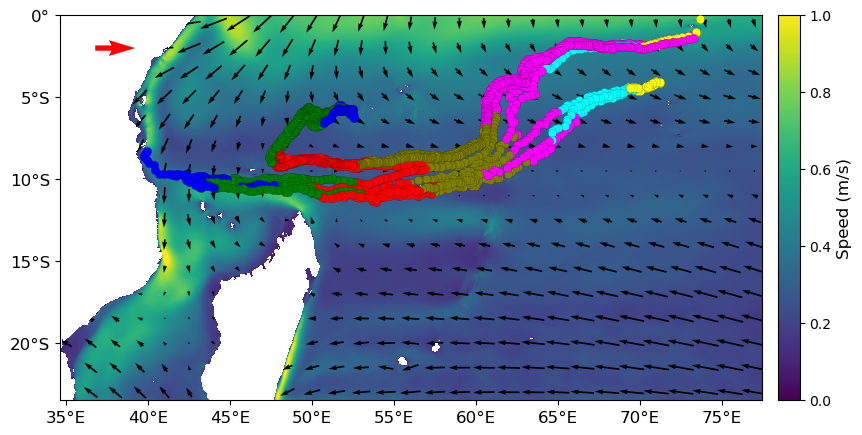

/tmp/ipykernel_3626069/2127882512.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks_labels)
/tmp/ipykernel_3626069/2127882512.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


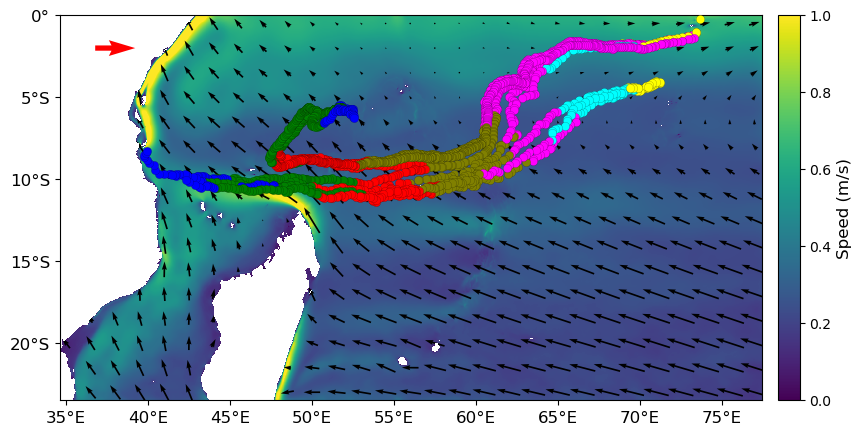

/tmp/ipykernel_3626069/2127882512.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks_labels)
/tmp/ipykernel_3626069/2127882512.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


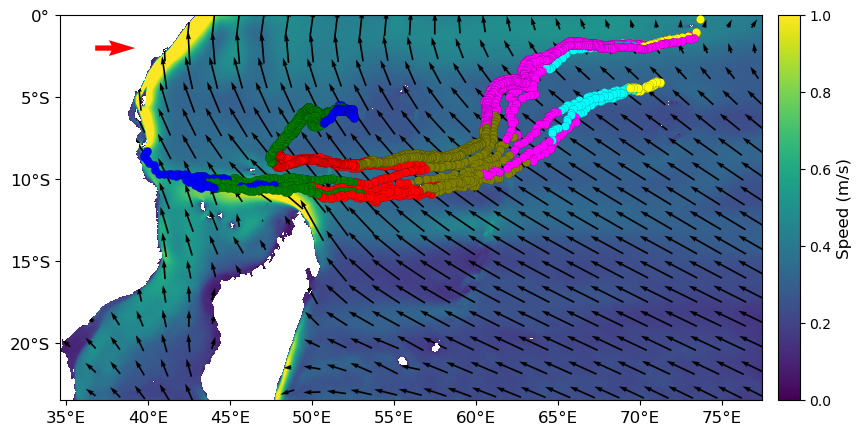

/tmp/ipykernel_3626069/2127882512.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks_labels)
/tmp/ipykernel_3626069/2127882512.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


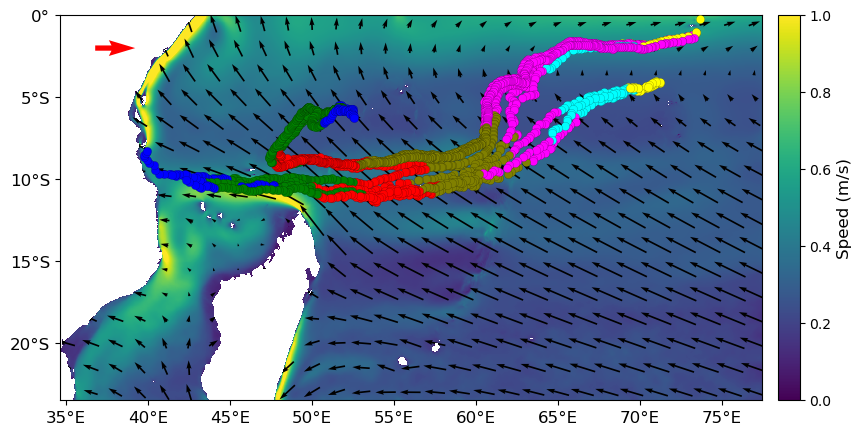

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import cmasher as cmr
import os
import pandas as pd
ds_current = xr.open_dataset('/home/ocean_personal_data/albinski/WINDS-M_SFC_DAY_MONMEAN_LSM.rho.nc')
ds_wind = xr.open_dataset('/home/ocean_personal_data/albinski/ERA5_u10_seasclim.nc')
grid = xr.open_dataset('/home/ocean_personal_data/albinski/croco_grd.nc')

def is_djf(month):
    return (month == 12) | (month <= 2)

def is_mam(month):
    return (3 <= month) & (month <= 5)

def is_jja(month):
    return (6 <= month) & (month <= 8)

def is_son(month):
    return (9 <= month) & (month <= 11)

seasons = {'DJF': is_djf, 'MAM': is_mam, 'JJA': is_jja, 'SON': is_son}

def plot_speed_and_wind_vectors(speed, u_wind, v_wind, title):
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    pcm = ax.pcolormesh(speed.nav_lon_rho, speed.nav_lat_rho, speed, shading='auto', vmin = 0, vmax = 1)
    cbar = plt.colorbar(pcm, ax=ax,label = 'Speed (m/s)', orientation='vertical', pad=0.01, aspect=17.5, fraction=0.03)
    cbar.set_label('Speed (m/s)', fontsize=12)
    formatter = FuncFormatter(lambda x, pos: f"{x:.1f}")
    cbar.formatter = formatter
    cbar.update_ticks()


    downsample_factor = 6
    lon = u_wind.longitude[::downsample_factor]
    lat = u_wind.latitude[::downsample_factor]
    u = u_wind[::downsample_factor, ::downsample_factor]
    v = v_wind[::downsample_factor, ::downsample_factor]
    
    ax.quiver(lon, lat, u, v, scale=25, scale_units='inches', color='black', pivot='middle', headwidth=3)


    ax.pcolormesh(grid.lon_psi[0, :],
              grid.lat_psi[:, 0],
              np.ma.masked_array(np.ones_like(grid.mask_rho[1:-1, 1:-1]),
                                 mask=grid.mask_rho[1:-1, 1:-1]),
              cmap=cmr.neutral_r)
    scale_lon = 38
    scale_lat = -2
    scale_u = 10
    scale_v = 0 
    
    ax.quiver(scale_lon, scale_lat, scale_u, scale_v, scale=25, scale_units = 'inches', color='red', pivot='middle', linewidth = 0.5)

    plt.xlim(np.amin(grid.lon_psi), np.amax(grid.lon_psi))
    plt.ylim(np.amin(grid.lat_psi), np.amax(grid.lat_psi))

    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(axis='both', which='major', labelsize=12)

    x_ticks = ax.get_xticks()
    y_ticks = ax.get_yticks()

    y_ticks_labels = [f"{int(abs(tick))}°S" if tick < 0 else f"{int(tick)}°" for tick in y_ticks]
    x_ticks_labels = [f"{int(tick)}°E" for tick in x_ticks]

    ax.set_yticklabels(y_ticks_labels)
    ax.set_xticklabels(x_ticks_labels)
    plt.savefig(f'wind_{title}.png', dpi=1000, format='png', bbox_inches='tight')

    directory = '/home/ocean_personal_data/albinski/bottle_data/'

    month_colors = {
        1: 'red', 2: 'green', 3: 'blue', 4: 'orange', 
        5: 'purple', 6: 'brown', 7: 'pink', 8: 'gray', 
        9: 'yellow', 10: 'cyan', 11: 'magenta', 12: 'olive'
    }

    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, filename))
            df['Month'] = pd.to_datetime(df['Msg Date'], dayfirst=True, errors='coerce').dt.month
            for month in df['Month'].unique():
                month_df = df[df['Month'] == month]
                plt.plot(month_df['Longitude'], month_df['Latitude'], zorder=100, marker='o', 
                         markerfacecolor=month_colors.get(month, 'black'), markeredgecolor='black', 
                         markeredgewidth=0.1, linestyle='None')

    plt.show()
    

for i, (season, season_func) in enumerate(seasons.items()):
    seasonal_speed = ds_current['speed'].where(season_func(ds_current['time_counter'].dt.month), drop=True).mean(dim='time_counter')
    seasonal_u_wind = ds_wind['u10'].isel(time=i)
    seasonal_v_wind = ds_wind['v10'].isel(time=i)
    plot_speed_and_wind_vectors(seasonal_speed, seasonal_u_wind, seasonal_v_wind, f'{season}')


## Combined wind and surface currents

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import cmasher as cmr

ds_current = xr.open_dataset('/home/ocean_personal_data/albinski/WINDS-M_SFC_DAY_MONMEAN_LSM.rho.nc')
ds_wind = xr.open_dataset('/home/ocean_personal_data/albinski/ERA5_u10_seasclim.nc')
grid = xr.open_dataset('/home/ocean_personal_data/albinski/croco_grd.nc')

def is_djf(month):
    return (month == 12) | (month <= 2)

def is_mam(month):
    return (3 <= month) & (month <= 5)

def is_jja(month):
    return (6 <= month) & (month <= 8)

def is_son(month):
    return (9 <= month) & (month <= 11)

seasons = {'DJF': is_djf, 'MAM': is_mam, 'JJA': is_jja, 'SON': is_son}

fig, axs = plt.subplots(4, 1, figsize=(20, 19), sharex=True, sharey=True)
fig.subplots_adjust(right=0.8, hspace=0.3)
cbar_ax = fig.add_axes([0.79, 0.113, 0.02, 0.76])


for i, (season, season_func) in enumerate(seasons.items()):
    seasonal_speed = ds_current['speed'].where(season_func(ds_current['time_counter'].dt.month), drop=True).mean(dim='time_counter')
    seasonal_u_current = ds_current['u_surf'].where(season_func(ds_current['time_counter'].dt.month), drop=True).mean(dim='time_counter')
    seasonal_v_current = ds_current['v_surf'].where(season_func(ds_current['time_counter'].dt.month), drop=True).mean(dim='time_counter')
    seasonal_u_wind = ds_wind['u10'].isel(time=list(seasons).index(season))
    seasonal_v_wind = ds_wind['v10'].isel(time=list(seasons).index(season))
    
    downsample_factor = 40
    lon_current = seasonal_speed.nav_lon_rho[::downsample_factor, ::downsample_factor]
    lat_current = seasonal_speed.nav_lat_rho[::downsample_factor, ::downsample_factor]
    u_current = seasonal_u_current[::downsample_factor, ::downsample_factor]
    v_current = seasonal_v_current[::downsample_factor, ::downsample_factor]

    downsample_factor_wind = 8
    lon_wind = seasonal_u_wind.longitude[::downsample_factor_wind]
    lat_wind = seasonal_u_wind.latitude[::downsample_factor_wind]
    u_wind = seasonal_u_wind[::downsample_factor_wind, ::downsample_factor_wind]
    v_wind = seasonal_v_wind[::downsample_factor_wind, ::downsample_factor_wind]
    
    ax = axs[i]
    pcm = ax.pcolormesh(grid.lon_rho, grid.lat_rho, seasonal_speed, shading='auto', vmin=0, vmax=1)
    ax.quiver(lon_current, lat_current, u_current, v_current, scale=1, scale_units='inches', color='black', pivot='middle', headwidth=2)
    ax.quiver(lon_wind, lat_wind, u_wind, v_wind, scale=15, scale_units='inches', color='red', pivot='middle', headwidth=3)
    ax.pcolormesh(grid.lon_psi[0, :],
          grid.lat_psi[:, 0],
          np.ma.masked_array(np.ones_like(grid.mask_rho[1:-1, 1:-1]),
                             mask=grid.mask_rho[1:-1, 1:-1]),
          cmap=cmr.neutral_r)
    plt.xlim(np.amin(grid.lon_psi), np.amax(grid.lon_psi))
    plt.ylim(np.amin(grid.lat_psi), np.amax(grid.lat_psi))
    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(axis='both', which='major', labelsize=12)
    x_ticks = ax.get_xticks()
    y_ticks = ax.get_yticks()
    y_ticks_labels = [f"{int(abs(tick))}°S" if tick < 0 else f"{int(tick)}°" for tick in y_ticks]
    x_ticks_labels = [f"{int(tick)}°E" for tick in x_ticks]
    ax.set_yticklabels(y_ticks_labels)
    ax.set_xticklabels(x_ticks_labels)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(f'{season}', fontsize = 15)


plt.xlim(np.amin(grid.lon_psi), np.amax(grid.lon_psi))
plt.ylim(np.amin(grid.lat_psi), np.amax(grid.lat_psi))
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Surface Current Speed (m/s)', fontsize=14)
formatter = FuncFormatter(lambda x, pos: f"{x:.1f}")
cbar.formatter = formatter
cbar.update_ticks()

plt.show()



## Combined plot for wind DJF and JJA

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import cmasher as cmr

ds_current = xr.open_dataset('/home/ocean_personal_data/albinski/WINDS-M_SFC_DAY_MONMEAN_LSM.rho.nc')
ds_wind = xr.open_dataset('/home/ocean_personal_data/albinski/ERA5_u10_seasclim.nc')
grid = xr.open_dataset('/home/ocean_personal_data/albinski/croco_grd.nc')

def is_djf(month):
    return (month == 12) | (month <= 2)

def is_jja(month):
    return (6 <= month) & (month <= 8)

seasons = {'DJF': is_djf, 'JJA': is_jja}

def plot_speed_and_wind_vectors(speed, u_wind, v_wind, title, ax):
    pcm = ax.pcolormesh(speed.nav_lon_rho, speed.nav_lat_rho, speed, shading='auto', vmin=0, vmax=1)
    downsample_factor = 6
    lon = u_wind.longitude[::downsample_factor]
    lat = u_wind.latitude[::downsample_factor]
    u = u_wind[::downsample_factor, ::downsample_factor]
    v = v_wind[::downsample_factor, ::downsample_factor]
    ax.quiver(lon, lat, u, v, scale=25, scale_units='inches', color='black', pivot='middle', headwidth=3)
    ax.pcolormesh(grid.lon_psi[0, :], grid.lat_psi[:, 0], np.ma.masked_array(np.ones_like(grid.mask_rho[1:-1, 1:-1]), mask=grid.mask_rho[1:-1, 1:-1]), cmap=cmr.neutral_r)
    scale_lon = 38
    scale_lat = -2
    scale_u = 10
    scale_v = 0
    ax.quiver(scale_lon, scale_lat, scale_u, scale_v, scale=25, scale_units='inches', color='red', pivot='middle', linewidth=0.5)
    plt.xlim(np.amin(grid.lon_psi), np.amax(grid.lon_psi))
    plt.ylim(np.amin(grid.lat_psi), np.amax(grid.lat_psi))
    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(axis='both', which='major', labelsize=12)
    x_ticks = ax.get_xticks()
    y_ticks = ax.get_yticks()
    y_ticks_labels = [f"{int(abs(tick))}°S" if tick < 0 else f"{int(tick)}°" for tick in y_ticks]
    x_ticks_labels = [f"{int(tick)}°E" for tick in x_ticks]
    ax.set_yticklabels(y_ticks_labels)
    ax.set_xticklabels(x_ticks_labels)
    return pcm

fig, axs = plt.subplots(2, 1, figsize=(21, 11), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.2)
pcms = []
for i, (season, season_func) in enumerate(seasons.items()):
    seasonal_speed = ds_current['speed'].where(season_func(ds_current['time_counter'].dt.month), drop=True).mean(dim='time_counter')
    seasonal_u_wind = ds_wind['u10'].isel(time=(0 if season == 'DJF' else 2))
    seasonal_v_wind = ds_wind['v10'].isel(time=(0 if season == 'DJF' else 2))
    pcm = plot_speed_and_wind_vectors(seasonal_speed, seasonal_u_wind, seasonal_v_wind, season, axs[i])
    pcms.append(pcm)

for ax in axs:
    ax.grid(color='grey', linestyle='-', linewidth=0.9, zorder=0)
cbar = fig.colorbar(pcms[0], ax=axs.ravel().tolist(), orientation='vertical', pad=0.01, aspect=50, fraction=0.02)
axs[0].tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=True, labeltop=False)

cbar.set_label('Surface Current Speed (m/s)', fontsize=14)
formatter = FuncFormatter(lambda x, pos: f"{x:.1f}")
cbar.formatter = formatter
cbar.update_ticks()
plt.savefig('wind_DJF_JJA.png', dpi=1000, format='png', bbox_inches='tight')
plt.show()


## Figure 1 vector file plotting

/tmp/ipykernel_3626069/4030514799.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks_labels)
/tmp/ipykernel_3626069/4030514799.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels)


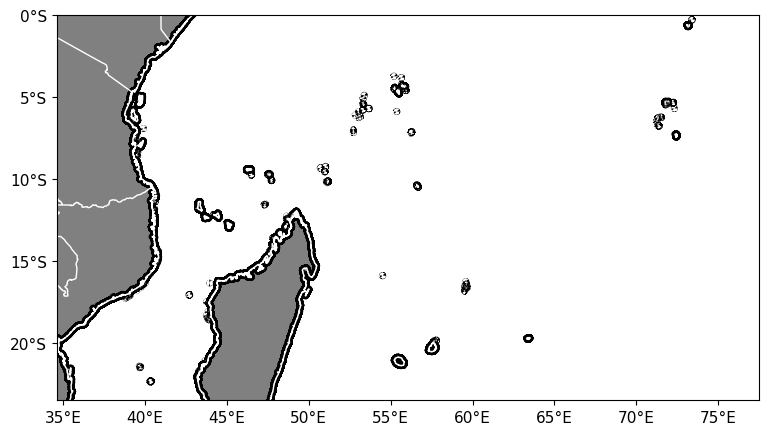

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cmasher as cmr
import xarray as xr
import numpy as np

grid = xr.open_dataset('/home/ocean_personal_data/albinski/croco_grd.nc')
shapefile_path = '/home/ocean_personal_data/albinski/shapefiles_for_figure1/'
lines = gpd.read_file('/home/ocean_personal_data/albinski/shapefiles_for_figure1_vectors/')

fig, ax = plt.subplots(1,1, figsize = (20,5))

plt.xlim(np.amin(grid.lon_psi), np.amax(grid.lon_psi))
plt.ylim(np.amin(grid.lat_psi), np.amax(grid.lat_psi))

gdf = gpd.read_file(shapefile_path)

gdf.boundary.plot(ax=ax, color='white', linewidth=1)
gdf.plot(ax=ax, color='grey', edgecolor='black', linewidth=5)
lines.plot(ax = ax, color = 'white', linewidth = 1)
ax.tick_params(axis='both', which='major', labelsize=11)

x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()

y_ticks_labels = [f"{int(abs(tick))}°S" for tick in y_ticks]

x_ticks_labels = [f"{int(tick)}°E" for tick in x_ticks]

ax.set_yticklabels(y_ticks_labels)
ax.set_xticklabels(x_ticks_labels)

ax.set_aspect('equal')
plt.show()


In [ ]:
fig, ax = plt.subplots(1,1, figsize = (21,6))

plt.xlim(np.amin(grid.lon_psi), np.amax(grid.lon_psi))
plt.ylim(np.amin(grid.lat_psi), np.amax(grid.lat_psi))

gdf = gpd.read_file(shapefile_path)

gdf.boundary.plot(ax=ax, color='black', linewidth=1)
gdf.plot(ax=ax, color='grey', edgecolor='white', linewidth=1)
lines.plot(ax = ax, color = 'white', linewidth = 1)
ax.tick_params(axis='both', which='major', labelsize=11)

x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()

y_ticks_labels = [f"{int(abs(tick))}°S" for tick in y_ticks]

x_ticks_labels = [f"{int(tick)}°E" for tick in x_ticks]

ax.set_yticklabels(y_ticks_labels)
ax.set_xticklabels(x_ticks_labels)

ax.set_aspect('equal')
plt.savefig('domain_map.png', dpi=1000, format='png', bbox_inches='tight')
plt.show()

## Speed within SEC current box over the year

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

ds = xr.open_dataset('/home/ocean_personal_data/albinski/WINDS-M_SFC_DAY_MONMEAN_LSM.rho.nc')

lat_min, lat_max = -11.7, -10.6
lon_min, lon_max = 47.5, 49.8

ds_box = ds.where((ds.nav_lat_rho >= lat_min) & (ds.nav_lat_rho <= lat_max) & 
                  (ds.nav_lon_rho >= lon_min) & (ds.nav_lon_rho <= lon_max), drop=True)

monthly_average_speeds = np.zeros(12)

for month in range(1, 13):
    monthly_data = ds_box['speed'].where(ds_box['time_counter'].dt.month == month, drop=True)
    monthly_speed = monthly_data.mean(dim=['time_counter', 'y_rho', 'x_rho'])
    monthly_average_speeds[month - 1] = monthly_speed.values

plt.figure(figsize=(8, 4))
plt.plot(range(1, 13), monthly_average_speeds, marker='', linestyle='-', color='blue')
plt.ylabel('Mean Surface Current Velocity (m/s)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Mean Surface Current Speed (m/s)', fontsize=13)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)
plt.yticks(fontsize=14)
plt.xlim (1,12)
plt.ylim(0,1)
plt.grid(True)
plt.savefig('domain_map.png', dpi=1000, format='png', bbox_inches='tight')
plt.show()

mean_speed = ds['speed'].mean(dim='time_counter')

fig, ax = plt.subplots(figsize=(10, 6))
speed_plot = ax.pcolormesh(ds['nav_lon_rho'], ds['nav_lat_rho'], mean_speed,
                           shading='auto', cmap='viridis')
cbar = plt.colorbar(speed_plot, ax=ax, orientation='vertical', pad=0.01, aspect=17.5, fraction=0.03, label='Normalised Risk')
cbar.set_label('Mean Surface Current Speed (m/s)', fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

box_lon = [lon_min, lon_max, lon_max, lon_min, lon_min]
box_lat = [lat_min, lat_min, lat_max, lat_max, lat_min]
ax.plot(box_lon, box_lat, color='red', linewidth=2, linestyle='--', label='Selected Area')

ax.legend(fontsize=14)
x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()

y_ticks_labels = [f"{int(abs(tick))}°S" for tick in y_ticks]

x_ticks_labels = [f"{int(tick)}°E" for tick in x_ticks]

ax.set_yticklabels(y_ticks_labels)
ax.set_xticklabels(x_ticks_labels)

ax.set_aspect('equal')
plt.show()
